In [1]:
import numpy as np
import os
import time
import datetime
import data_helpers
from text_cnn import TextCNN
import vocabulary
import word2vec
import generate_w2v

/Users/hugomoreau/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Importing the training data

In [7]:
positive_data_file = "../twitter-datasets/train_pos.txt"
negative_data_file = "../twitter-datasets/train_neg.txt"

# Load data from files
positive_examples = list(open(positive_data_file, "r").readlines())
positive_examples = [s.strip() for s in positive_examples]
positive_examples = data_helpers.delete_duplicate_lines(positive_examples)

negative_examples = list(open(negative_data_file, "r").readlines())
negative_examples = [s.strip() for s in negative_examples]
negative_examples = data_helpers.delete_duplicate_lines(negative_examples)

# Split by words
x_text = positive_examples + negative_examples

# Generate labels
positive_labels = [1 for _ in positive_examples]
negative_labels = [0 for _ in negative_examples]
y = positive_labels + negative_labels


Deleting duplicates in data...
Found : 9.767000000000001% duplicates in the input


Deleting duplicates in data...
Found : 8.912% duplicates in the input



## Generating the vocabulary

In [3]:
max_document_length = max([len(x.split(" ")) for x in x_text])

# We Generate our w2v
w2vfilelist =['../twitter-datasets/train_pos_full.txt','../twitter-datasets/train_neg_full.txt','../twitter-datasets/test_data.txt']
w2v_path = "../tweetdatabase_word2vec"
embedding_dim = 128

generate_w2v.generate_word2vec(w2vfilelist,w2v_path,embedding_dim)
w2v = word2vec.Word2vec(w2v_path)

# Get our embedding matrix
vocab_processor = vocabulary.Vocabulary(max_document_length,w2v,embedding_dim)
vocab_processor.fit(x_text)
embedding = vocab_processor.embeddingMatrix()

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

In [4]:
def sentences2vectors(text):
    # Now we will get our input matrix by taking for each sentence the 
    # vector corresponding to the average of the words vectors
    matrix_sentence_word_emb_index = vocab_processor.transform(text)
    sentence_vectors = []
    for sentence_vec_index in matrix_sentence_word_emb_index :
        word_array = np.vstack([embedding[idx] for idx in sentence_vec_index])
        sent_vec = np.mean(word_array,axis=0)
        sentence_vectors.append(sent_vec)
    X = np.vstack(sentence_vectors)
    return X

In [5]:
X = sentences2vectors(x_text)
Y = np.array(y)
print(Y.shape)
print(X.shape)

(2270482,)
(2270482, 128)


## Split our data into training and testing set

In [7]:
training_ratio = 0.8
testing_index = -1 * int(training_ratio * float(len(Y)))
shuffle_indices = np.random.permutation(np.arange(len(Y)))
X_shuffled = X[shuffle_indices]
Y_shuffled = Y[shuffle_indices]

In [8]:
X_train,X_test = X_shuffled[:testing_index],X_shuffled[testing_index:]
Y_train,Y_test = Y_shuffled[:testing_index],Y_shuffled[testing_index:]
print(Y_train.shape)
print(Y_test.shape)

(454097,)
(1816385,)


## Train a linear classifier

In [9]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X_train, Y_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [10]:
Y_test_pred = logreg.predict(X_test)

In [11]:
accurate_pred = 0
for i in range(len(Y_test_pred)):
    if(Y_test_pred[i] == Y_test[i]):
        accurate_pred += 1
accuracy = (accurate_pred/len(Y_test_pred))*100
print("The linear regression has an accuracy of : {:.6f}%".format(accuracy))

The linear regression has an accuracy of : 70.596982%


## Compute the cross-validation score over various lambdas

In [12]:
from sklearn.cross_validation import cross_val_score
lambdas = np.logspace(-5,4,30)
accuracies = []
for l in lambdas:
    logreg = linear_model.LogisticRegression(C=l, class_weight="balanced")
    scores = cross_val_score(logreg, X, Y, cv=5)
    accuracy = 100*scores.mean()
    accuracies.append(accuracy)
    print("with lambda = {} : accuracy = {:0.5f}(+/- {:0.3f})".format(l,accuracy, scores.std() * 2))

with lambda = 1e-05 : accuracy = 59.66848(+/- 0.001)
with lambda = 2.0433597178569438e-05 : accuracy = 59.43082(+/- 0.001)
with lambda = 4.1753189365604006e-05 : accuracy = 59.28340(+/- 0.001)
with lambda = 8.531678524172815e-05 : accuracy = 59.23007(+/- 0.000)
with lambda = 0.00017433288221999874 : accuracy = 59.24050(+/- 0.001)
with lambda = 0.0003562247890262444 : accuracy = 59.31899(+/- 0.001)
with lambda = 0.0007278953843983154 : accuracy = 59.47226(+/- 0.001)
with lambda = 0.0014873521072935117 : accuracy = 59.75612(+/- 0.001)
with lambda = 0.0030391953823131978 : accuracy = 60.18634(+/- 0.001)
with lambda = 0.006210169418915616 : accuracy = 60.81704(+/- 0.001)
with lambda = 0.01268961003167922 : accuracy = 61.78080(+/- 0.001)
with lambda = 0.02592943797404667 : accuracy = 63.22847(+/- 0.001)
with lambda = 0.05298316906283713 : accuracy = 65.09723(+/- 0.001)
with lambda = 0.1082636733874054 : accuracy = 66.94451(+/- 0.001)
with lambda = 0.22122162910704501 : accuracy = 68.37720(+

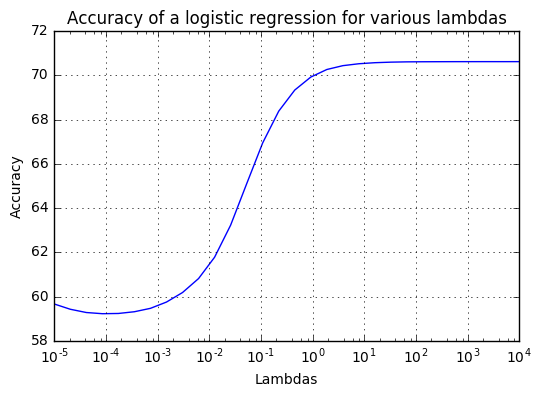

In [14]:
import matplotlib.pyplot as plt
plt.semilogx(lambdas, accuracies)
plt.title('Accuracy of a logistic regression for various lambdas')
plt.grid(True)
plt.xlabel('Lambdas')
plt.ylabel('Accuracy')
plt.savefig('LogRegAccuracy.png')
plt.show()
